# Pixel Co-Ordinates to Rotation angles
Input: 
* 2 videos - mockPitch.avi, mockYaw.avi. Approximate movement of 90 degrees each - consecutive frame analysis gives only per degree change in pitch/ yaw
* 4 images - p1.PNG, p2.PNG, y1.PNG, y2.PNG - 2 images for pitch and yaw respectively. - these frames assumed to have 2 degree change in pitch/ yaw

Output: 
* Stage 1 - csv file with extracted features from given videos / images
* Stage 2 - NN model for training the pixels to rotation angles

## Imports

In [5]:
import pandas as pd
import numpy as np
import cv2
import csv
from matplotlib import pyplot as plt

## Video inputs

In [7]:
mockPitch = 'mockPitch.avi'
mockYaw = 'mockYaw.avi'

## Number of frames in each video

In [8]:
capPitch = cv2.VideoCapture(mockPitch)
capYaw = cv2.VideoCapture(mockYaw)
framesPitch = int(capPitch.get(cv2.CAP_PROP_FRAME_COUNT))
framesYaw = int(capYaw.get(cv2.CAP_PROP_FRAME_COUNT))
print(framesPitch, framesYaw)
# length of each video in seconds
timePitch_s = 7
timeYaw_s = 8

393 429


Assuming smooth movement of camera covering 90degrees each

In [9]:
framesPerPitchStep = int(framesPitch / 90)
framesPerYawStep = int(framesYaw / 90)
print(framesPerPitchStep, framesPerYawStep)

4 4


## Detecting features between two frames using ORB - Given two frames where yaw and pitch are known
Refer https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

In [6]:
# Function which takes 2 frames, index of frames, known angles and outputs a list which contains the frame information along with matched feature points position
def featureMatch(img1, img2, startFrame, endFrame, roll, pitch, yaw, listOp):
    
    # Initiate ORB detector
    orb = cv2.ORB_create()
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Initialize lists to store keypoints 
    list_kp1 = []
    list_kp2 = []

    # For each match...
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        # Append to each list
        list_kp1.append((x1, y1))
        list_kp2.append((x2, y2))
        
    list_i = [(startFrame, endFrame) + startPt + endPt + (roll, pitch, yaw) for startPt, endPt in zip(list_kp1, list_kp2)]
    listOp.extend(list_i)
    
    # for viewing un-comment the following to see top 30 features matching lines, and press escape to close the window
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:30], None,flags=2)
    imgResize = cv2.resize(img3, (1080, 480)) 
    cv2.imshow('Feature Matching',imgResize)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


## Create a csv file with necessary information for training
Assuming 2 images p1 and p2 where p1 is first frame in a video and p2 is fifth frame in the same video, where the video is roated to 2 degrees in pitch. Similarly y1 and y2 for yaw.

In [14]:
img1 = cv2.imread('p1.PNG')
img2 = cv2.imread('p2.PNG')
listPOp = []
featureMatch(img1, img2, 1, 5, 0, 2, 0, listPOp)
img1 = cv2.imread('y1.PNG')
img2 = cv2.imread('y2.PNG')
listYOp = []
featureMatch(img1, img2, 1, 5, 0, 0, 2, listYOp)

Combine both the list such that each row in csv contains one matched feature in particular frame

In [15]:
listPY = listPOp + listYOp
with open('tempPitchYaw.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['StartFrame','EndFrame','x1','y1','x2','y2','Roll','Pitch','Yaw'])
    for row in listPY:
        csv_out.writerow(row)

## Read the created csv

In [16]:
df = pd.read_csv('tempPitchYaw.csv')
df.head()
df.describe()

,StartFrame,EndFrame,x1,y1,x2,y2,Roll,Pitch,Yaw
count,376.0,376.0,376.000000,376.000000,376.000000,376.000000,376.0,376.000000,376.000000
mean,1.0,5.0,314.046761,473.839105,254.209281,549.064104,0.0,0.962766,1.037234
std,0.0,0.0,86.836342,132.563254,96.896853,95.930353,0.0,1.000638,1.000638
min,1.0,5.0,74.880005,156.764191,48.960003,340.070435,0.0,0.000000,0.000000
25%,1.0,5.0,252.046112,362.970016,238.896015,505.387184,0.0,0.000000,0.000000
50%,1.0,5.0,328.458313,472.780914,271.226959,531.480042,0.0,0.000000,2.000000
75%,1.0,5.0,391.164001,544.440063,302.400024,583.414673,0.0,2.000000,2.000000
max,1.0,5.0,474.000000,873.000000,466.000000,862.272095,0.0,2.000000,2.000000


## Feature detection for mock videos, it is assumed that for every 4 frames there is 1 degree change in pitch or yaw. csv is created such that it records absolute angles from start of the video to that present frame

## Detecting features between consecutive frames using ORB 
Refer https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

## For Pitch mock video

In [10]:
ret,img1 = capPitch.read()

# initialize counter so that for every 4 frames, there is 1 degree increase in pitch
counter = 0

# Assuming roll and yaw = 0, as the video is tried to shot for the same
roll = 0
yaw = 0
# Initialize pitch to 0
pitch = 0

list_pitch = []

# Initiate ORB detector
orb = cv2.ORB_create()
    
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

while(1):
    ret,img2 = capPitch.read()
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Initialize lists to store keypoints 
    list_kp1 = []
    list_kp2 = []

    # For each match...
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        # Append to each list
        list_kp1.append((x1, y1))
        list_kp2.append((x2, y2))
    
    
    startFrame = counter + 1
    endFrame = startFrame + 1
    
    if (counter % 4 == 0):
        pitch = pitch + 1
    
    
    list_pitch_i = [(startFrame, endFrame) + startPt + endPt + (roll, pitch, yaw) for startPt, endPt in zip(list_kp1, list_kp2)]
    list_pitch.extend(list_pitch_i)
    
    # for viewing un-comment the following to see top 30 features matching lines, and press escape to close the window
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:30], None,flags=2)
    imgResize = cv2.resize(img3, (1080, 480)) 
    cv2.imshow('Feature Matching',imgResize)
    
    img1 = img2.copy()
    counter = counter + 1
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
cv2.destroyAllWindows()
capPitch.release()

In [17]:
len(list_pitch)

list_pitch[132949]

listPitch = list_pitch.copy()

len(listPitch)

## For Yaw mock video

In [19]:
ret,img1 = capYaw.read()

# initialize counter so that for every 4 frames, there is 1 degree increase in yaw
counter = 0

# Assuming roll and pitch = 0, as the video is tried to shot for the same
roll = 0
pitch = 0
# Initialize pitch to 0
yaw = 0

list_yaw = []

# Initiate ORB detector
orb = cv2.ORB_create()
    
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

while(1):
    ret,img2 = capYaw.read()
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Initialize lists to store keypoints 
    list_kp1 = []
    list_kp2 = []

    # For each match...
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        # Append to each list
        list_kp1.append((x1, y1))
        list_kp2.append((x2, y2))
    
    
    startFrame = counter + 1
    endFrame = startFrame + 1
    
    if (counter % 4 == 0):
        yaw = yaw + 1
    
    
    list_yaw_i = [(startFrame, endFrame) + startPt + endPt + (roll, pitch, yaw) for startPt, endPt in zip(list_kp1, list_kp2)]
    list_yaw.extend(list_yaw_i)
    
    # for viewing un-comment the following to see top 30 features matching lines, and press escape to close the window
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:30], None,flags=2)
    imgResize = cv2.resize(img3, (1080, 480)) 
    cv2.imshow('Feature Matching',imgResize)
    
    img1 = img2.copy()
    counter = counter + 1
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
cv2.destroyAllWindows()
capYaw.release()

In [24]:
len(list_yaw)

listYaw = list_yaw.copy()

listYaw[0]

## Combine mock pitch and yaw

In [25]:
list_pix_ang = listPitch + listYaw
len(list_pix_ang)

284417

## Create csv for training

In [26]:
with open('angPitchYaw.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['StartFrame','EndFrame','x1','y1','x2','y2','AbsoluteRoll','AbsolutePitch','AbsoluteYaw'])
    for row in list_pix_ang:
        csv_out.writerow(row)

In [19]:
df = pd.read_csv('angPitchYaw.csv')
df.describe()

,StartFrame,EndFrame,x1,y1,x2,y2,AbsoluteRoll,AbsolutePitch,AbsoluteYaw
count,284417.000000,284417.000000,284417.000000,284417.000000,284417.000000,284417.000000,284417.0,284417.000000,284417.000000
mean,196.185133,197.185133,1012.195500,486.033453,1008.945408,488.373620,0.0,22.075488,27.345981
std,111.848154,111.848154,413.241398,238.404598,413.643323,237.718436,0.0,29.611792,33.351889
min,1.000000,2.000000,33.000000,31.000000,31.000000,31.000000,0.0,0.000000,0.000000
25%,101.000000,102.000000,752.000000,284.400024,746.496094,289.200012,0.0,0.000000,0.000000
50%,198.000000,199.000000,1014.000000,507.000000,1012.320068,507.617432,0.0,0.000000,7.000000
75%,293.000000,294.000000,1285.632202,646.272034,1281.600098,647.958679,0.0,45.000000,55.000000
max,404.000000,405.000000,1888.000000,1046.000000,1888.000000,1048.000000,0.0,91.000000,101.000000


# Machine Learning Model

Create a new dataframe, from the 2 csvs where AbsoluteRoll/AbsolutePitch=1 in the later and roll/pitch=2 in the former

In [33]:
dfPY = pd.read_csv('tempPitchYaw.csv')
dfPY.head()

dfExt = df.loc[(df['AbsolutePitch'] == 1) | (df['AbsoluteYaw'] == 1)]
dfExt.rename(columns={'AbsolutePitch':'Pitch', 'AbsoluteYaw':'Yaw'}, inplace=True)

dfPY = dfPY.append(dfExt)
dfPY.drop(columns=['AbsoluteRoll'], inplace=True)

In [39]:
dfPY['dx'] = dfPY['x1']-dfPY['x2']
dfPY['dy'] = dfPY['y1']-dfPY['y2']
dfPY.tail()

,StartFrame,EndFrame,x1,y1,x2,y2,Roll,Pitch,Yaw,dx,dy
134522,4,5,987.033752,551.577698,980.812927,553.651306,NaN,0,1,6.220825,-2.073608
134523,4,5,1109.000000,479.000000,1103.000000,478.000000,NaN,0,1,6.000000,1.000000
134524,4,5,1101.081787,456.192078,1096.934570,456.192078,NaN,0,1,4.147217,0.000000
134525,4,5,505.200012,597.600037,498.000000,598.000000,NaN,0,1,7.200012,-0.399963
134526,4,5,844.800049,578.400024,840.960022,577.440002,NaN,0,1,3.840027,0.960022


## Keep top 30 matches in each frame set and discard others to remove outliers

In [63]:
dfCleaning = dfPY.copy()
dfProcessed = dfCleaning.groupby(['StartFrame', 'EndFrame', 'Pitch', 'Yaw']).head(30)
dfCleaning.groupby(['StartFrame', 'EndFrame', 'Pitch', 'Yaw']).head(2)

,StartFrame,EndFrame,x1,y1,x2,y2,Roll,Pitch,Yaw,dx,dy
0,1,5,249.000000,699.000000,244.000000,843.000000,0.0,2,0,5.000000,-144.000000
1,1,5,260.640015,328.320007,258.000000,523.200012,0.0,2,0,2.640015,-194.880005
181,1,5,185.760010,704.160034,72.000000,707.040039,0.0,0,2,113.760010,-2.880005
182,1,5,370.759766,363.294800,251.320374,353.341522,0.0,0,2,119.439392,9.953278
0,1,2,845.630920,125.411362,845.630920,128.994553,NaN,1,0,0.000000,-3.583191
1,1,2,798.336121,953.856140,798.336121,958.003357,NaN,1,0,0.000000,-4.147217
356,2,3,1058.400024,82.080002,1058.400024,86.400002,NaN,1,0,0.000000,-4.320000
357,2,3,953.026794,958.003418,953.026794,962.980042,NaN,1,0,0.000000,-4.976624
717,3,4,1164.000000,154.000000,1163.000000,159.000000,NaN,1,0,1.000000,-5.000000
718,3,4,933.120239,958.003418,933.120239,962.980042,NaN,1,0,0.000000,-4.976624


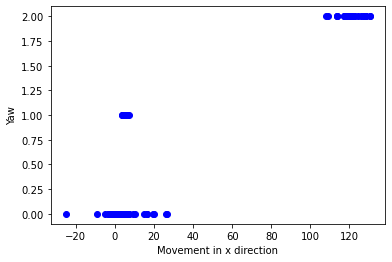

In [71]:
plt.scatter([dfProcessed.dx], [dfProcessed.Yaw],  color='blue')
plt.xlabel("Movement in x direction")
plt.ylabel("Yaw")
plt.show()

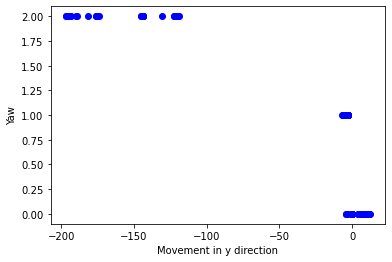

In [72]:
plt.scatter([dfProcessed.dy], [dfProcessed.Pitch],  color='blue')
plt.xlabel("Movement in y direction")
plt.ylabel("Yaw")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8DDFDC6A0>,
      dtype=object)

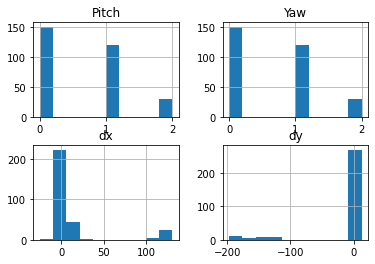

In [73]:
viz = dfProcessed[['dx','dy','Pitch','Yaw']]
viz.hist()

## Selection of machine learning model

Regression model is the best suited for this application. 
Choosing between simple linear regression, non-linear regression, multiple, polynomial regression is dependent on how the dependent variables(roll, pitch, yaw) change with respect to independent variables(dx, dy)

## Going ahead with Polynomial Regression - just a quick jot

In [77]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn import linear_model

msk = np.random.rand(len(dfProcessed)) < 0.8
train = dfProcessed[msk]
test = dfProcessed[~msk]
train_x = np.asanyarray(train[['dx', 'dy']])
train_y = np.asanyarray(train[['Pitch', 'Yaw']])

test_x = np.asanyarray(test[['dx', 'dy']])
test_y = np.asanyarray(test[['Pitch', 'Yaw']])


poly3 = PolynomialFeatures(degree=3)
train_x_poly3 = poly3.fit_transform(train_x)
model3 = linear_model.LinearRegression()
train_y3_ = model3.fit(train_x_poly3, train_y)
# The coefficients
print ('Coefficients: ', model3.coef_)
print ('Intercept: ',model3.intercept_)
test_x_poly3 = poly3.fit_transform(test_x)
test_y3_ = model3.predict(test_x_poly3)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y3_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y3_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y3_ , test_y) )


Coefficients:  [[ 0.00000000e+00 -1.74437998e-02 -1.89342517e-01  5.13065076e-04
  -8.52534162e-04 -2.18554915e-03 -3.19110327e-06  2.22610437e-05
  -1.59613294e-07 -6.43300680e-06]
 [ 0.00000000e+00  2.04919224e-02  1.85248296e-01 -3.76610408e-04
   1.00355251e-03  2.26050161e-03  2.43814029e-06 -2.33855331e-05
   5.34993629e-07  6.78356193e-06]]
Intercept:  [0.13030961 0.848719  ]
Mean absolute error: 0.10
Residual sum of squares (MSE): 0.02
R2-score: 0.94


# Further Steps

* Trying to find disparity map by stereo correspondence between 2 images (assuming stereo vision functionality). if the disparity map is found, then that could also be used a dependent variable for each matched point in our training - not successful till now
* Mock videos should be replaced with real videos and corresponding roll, pitch, yaw
* Analyse the data and confirm the machine learning model